### GLM : Poisson Regression
A minimal reproductable example of poisson regression to predict counts using dummy data

In [1]:
import numpy as np
import re
import sys
import seaborn as sns
import warnings
import pandas as pd
import patsy as pt ##help building design Matrix with a one-to-many relatioship
import scipy

import pymc3 as pm
import theano.tensor as T
import theano
from matplotlib import pyplot as plt

warnings.filterwarnings('ignore')

sns.set(style = "darkgrid", palette = "muted")
pd.set_option("display.mpl_style", "default")
plt.rcParams["figure.figsize"] = 14, 6
np.random.seed(0)
%matplotlib inline

In [2]:
import json
import matplotlib


root = r"/Users/Kenneth-Aristide/anaconda3/bin/python_prog/ML/styles/bmh_matplotlibrc.json"
s = json.load(open(root))
matplotlib.rcParams.update(s)
colors = ["#348ABD", "#A60628", "#7A68A6", "#467821"]

In [3]:
def strip_derived_rvs(rvs):
    """
    Convenience  function:
        remove PyMC3-generated RVs from a list
    """
    ret_rvs = []
    for rv in rvs:
        if not (re.search("_log", rv.name) or re.search("_interval", rv.name)):
            ret_rvs.append(rv)
    return ret_rvs

def plot_traces_pymc(traces, varnames = None):
    """
    Convenience function:
        plot trace with overlaid means and values
    """
    
    nrows = len(trace.varnames)
    if varnames is not None:
        nrows = len(varnames)
    ax = pm.traceplot(trace, varnames = varnames, figsize = (12, nrows*1.4),
                     lines = {k: v['mean'] for k, v in pm.df_summary(trace, varnames = varnames).iterrows()})
    
    for i, mn in enumerate(pm.df_summary(trace, varnames = varnames)['mean']):
        ax[i, 0].annotate("{:.2f}".format(mn), xy = (mn, 0), xycoords = "data", xytext = (5, 10),
                         textcoords = "offset points", rotation = 90, va= "bottom", fontsize = "large",
                         color = "#AA0022")
        

### Generate data
1. the subject sneezes N times per day, recorded ad $nsneeze(int)$.
2. The subject may or may not drin alcohol during that day, recorded as $alcohol(boolean)$.
3. The subject may or may not take an antihistamine medication during that day, recorded as the negative action $nomeds(boolean)$.
4. The sampler postulatethat sneezing occurs at some baseline rate, which increase if an antihistamine is not taken, and futher increased after alcohol is consumed.
5. The data is aggregated per day, to yield a total count of sneezes on that day, with a boolean flag for alcohol and antihistaline usage, with the big assumption that nsneezes have a direct causal relationship.


In [4]:
## decide poisson theta values

theta_noalcohol_meds = 1 # no alcohol, took an antihist
theta_alcohol_meds = 3  # alcohol, to an antihist
theta_noalcohol_nomeds = 6 # no alcohol, no antihist
theta_alcohol_nomeds = 36 # alcohol, no antihist

## create samples

q = 1000
df = pd.DataFrame({
        'nsneeze': np.concatenate((np.random.poisson(theta_noalcohol_meds, q),
                                 np.random.poisson(theta_alcohol_meds, q),
                                 np.random.poisson(theta_noalcohol_nomeds, q),
                                 np.random.poisson(theta_alcohol_nomeds, q))),
        
        'alcohol': np.concatenate((np.repeat(False, q),
                                 np.repeat(True, q),
                                 np.repeat(False, q),
                                 np.repeat(True, q))),
        
        'nomeds' : np.concatenate((np.repeat(False, q),
                                 np.repeat(False, q), 
                                 np.repeat(True, q),
                                 np.repeat(True, q)))
    })
df.tail()

,alcohol,nomeds,nsneeze
3995,True,True,38
3996,True,True,31
3997,True,True,30
3998,True,True,34
3999,True,True,36


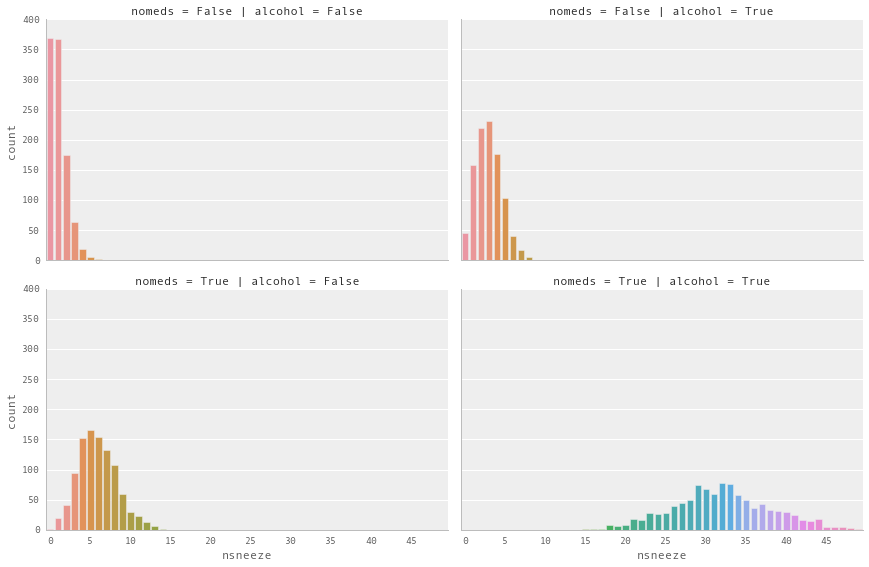

In [5]:
g = sns.factorplot(x = "nsneeze", row = "nomeds", col = "alcohol", data = df,
                  kind = "count", size = 4, aspect = 1.5)
## Make x-axis tickslabels less crowded
ax = g.axes[1, 0]
labels = np.arange(len(ax.get_xticklabels(which = 'both')))
ax.set_xticks(labels[::5])
ax.set_xticklabels(labels[::5]);

Our model is a very simple $Poisson$ $regression$ allowing for interaction of terms : 


$$\begin{aligned}
  \theta &\sim \mathcal{Exp}(\beta X) \\
  Y_{SneezeCount} &\sim \mathcal{Poisson}(\theta) \\
\end{aligned}$$

In [6]:
fml = 'nsneeze ~ alcohol + nomeds + alcohol:nomeds'# full patsy formulation
#fml = 'nsneeze ~ alcohol * nomeds' # alternative lazy patsy formulation
(mx_en, mx_ex) = pt.dmatrices(fml, df, return_type = 'dataframe', NA_action = 'raise')
pd.concat((mx_ex.head(3), mx_ex.tail(3)))

,Intercept,alcohol[T.True],nomeds[T.True],alcohol[T.True]:nomeds[T.True]
0,1.0,0.0,0.0,0.0
1,1.0,0.0,0.0,0.0
2,1.0,0.0,0.0,0.0
3997,1.0,1.0,1.0,1.0
3998,1.0,1.0,1.0,1.0
3999,1.0,1.0,1.0,1.0


In [7]:
with pm.Model() as PoiReg_model:
    
    ## define priors, weakly informative normal
    b0 = pm.Normal("Intercept", mu = 0, sd = 10)
    b1 = pm.Normal("alcohol[T.True]", mu = 0, sd = 10)
    b2 = pm.Normal("nomeds[T.True]", mu = 0, sd = 10)
    b3 = pm.Normal("alcohol[T.True]:nomeds[T.True]", mu = 0, sd = 10)
    
    ## define linear model and ex link function
    theta =( b0 * mx_ex['Intercept'] + 
             b1 * mx_ex['alcohol[T.True]'] + 
             b2 * mx_ex['nomeds[T.True]'] + 
             b3 * mx_ex['alcohol[T.True]:nomeds[T.True]'] )
    
    ## Likelihood
    sneeze_like = pm.Poisson("obs", mu = np.exp(theta), observed = mx_en['nsneeze'].values)
    
    ## Optimization
    start = pm.find_MAP(fmin = scipy.optimize.fmin_powell)
    step = pm.NUTS(scaling = start)
    
    ## Sampling
    trace = pm.sample(20000, start = start, step = step) #njobs = 2 to be explain
    burned_PoiRegression = trace[10000:]  

Optimization terminated successfully.
         Current function value: 8723.943403
         Iterations: 9
         Function evaluations: 445


100%|██████████| 20000/20000 [04:15<00:00, 78.26it/s] 


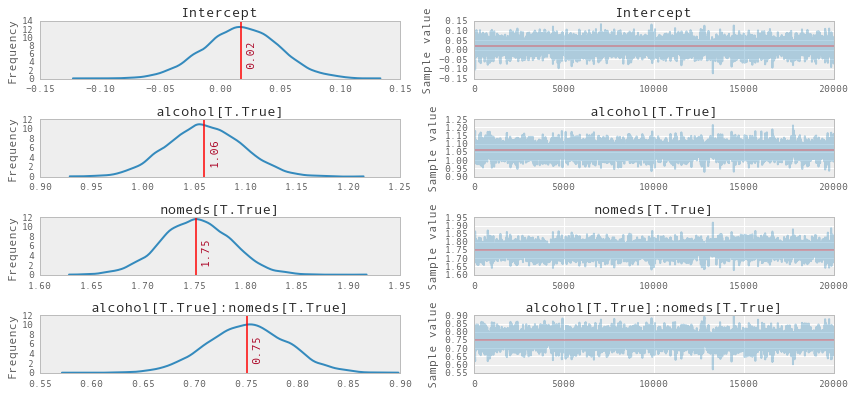

In [8]:
rvs_ = [rv.name for rv in strip_derived_rvs(PoiReg_model.unobserved_RVs)]
plot_traces_pymc(burned_PoiRegression, varnames = rvs_)

In [9]:
np.exp(pm.df_summary(burned_PoiRegression, varnames = rvs_)[['mean', 'hpd_2.5', 'hpd_97.5']])

,mean,hpd_2.5,hpd_97.5
Intercept,1.017021,0.956060,1.080235
alcohol[T.True],2.888309,2.693848,3.102040
nomeds[T.True],5.769172,5.402594,6.162441
alcohol[T.True]:nomeds[T.True],2.117770,1.960147,2.281320


Observe | The contributions from each feature as a multiplier of the baseline sneezecount appear to be as per the data generation:
    1. exp(b0_intercept): mean = 1.02 cr = [0.96, 1.08]
       Roughly linear baseline count when no alcohol and meds, as per the generated data:
            theta_noalcohol_meds = 1 (as set above) theta_noalcohol_meds = exp(b0_intercept) = 1
            
    2. exp(b1_alcohol): mean = 2.88 cr = [2.69, 3.09]
        non-zero positive effect of adding alcohol, a ~3x multiplier of baseline sneeze count, as per the generated data:
        theta_alcohol_meds = 3 (as set above) theta_alcohol_meds = exp(b0_intercept + b1_alcohol) = exp(b0_intercept) *               exp(b1_alcohol) = 1 * 3 = 3
    
    3. exp(b2_nomeds[T.True]): mean = 5.76 cr = [5.40, 6.17]
       larger, non-zero positive effect of adding nomeds, a ~6x multiplier of baseline sneeze count, as per the generated data:
       theta_noalcohol_nomeds = 6 (as set above) theta_noalcohol_nomeds = exp(b0_intercept + b2_nomeds) = exp(b0_intercept) * exp(b2_nomeds) = 1 * 6 = 6
     
    4. exp(b3_alcohol[T.True]:nomeds[T.True]): mean = 2.12 cr = [1.98, 2.30]
       small, positive interaction effect of alcohol and meds, a ~2x multiplier of baseline sneeze count, as per the generated data:
       theta_alcohol_nomeds = 36 (as set above) theta_alcohol_nomeds = exp(b0_intercept + b1_alcohol + b2_nomeds + b3_alcohol:nomeds) = exp(b0_intercept) * exp(b1_alcohol) * exp(b2_nomeds * b3_alcohol:nomeds) = 1 * 3 * 6 * 2 = 36



In [10]:
## Alternative method
with pm.Model() as PoiReg_model_alt:
    
    family = pm.glm.families.Poisson()
    pm.glm.glm(fml, df, family = family)
    
    ## Optimization
    start = pm.find_MAP(fmin = scipy.optimize.fmin_powell)
    step = pm.NUTS(scaling = start)
    
    ## Sampling
    trace_alt = pm.sample(20000, start = start, step = step, njobs = 1)
    burned_PoiReg_alt = trace_alt[10000:]

Optimization terminated successfully.
         Current function value: 8771.116059
         Iterations: 9
         Function evaluations: 549


100%|██████████| 20000/20000 [04:25<00:00, 75.39it/s]


In [11]:
rvs_

['Intercept',
 'alcohol[T.True]',
 'nomeds[T.True]',
 'alcohol[T.True]:nomeds[T.True]']

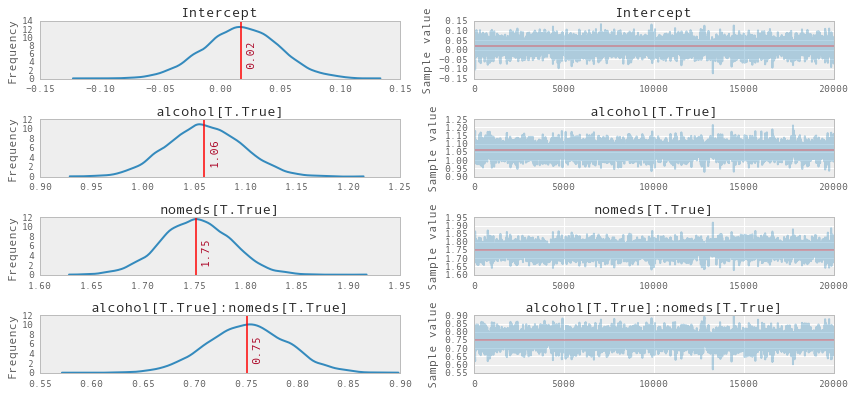

In [12]:
rvs_ = [rv.name for rv in strip_derived_rvs(PoiReg_model_alt.unobserved_RVs)]
plot_traces_pymc(burned_PoiReg_alt, varnames = rvs_[:-1])

In [13]:
np.exp(pm.df_summary(burned_PoiReg_alt, varnames = rvs_)[['mean', 'hpd_2.5', 'hpd_97.5']])

,mean,hpd_2.5,hpd_97.5
Intercept,1.016662e+00,0.957638,1.079234e+00
alcohol[T.True],2.890175e+00,2.698438,3.101798e+00
nomeds[T.True],5.769132e+00,5.409610,6.144776e+00
alcohol[T.True]:nomeds[T.True],2.117090e+00,1.961751,2.275405e+00
mu,7.083975e+29,1.001637,1.074559e+52


#### GLM : Negative Binomial Regression
This part demonstrate $negative$ $binomial$ $Regression$ using $glm$ submodule.
As in the Poisson regression above, we assume that sneezing occurs at some baseline rate, and that consuming alcohol,not taking antihistamines,or doing both increase its frequency.

In [14]:
df.groupby(['nomeds', 'alcohol'])['nsneeze'].agg(['mean', 'var'])
## Since the mean and the variance of a Poisson distributed random variable are equal, 
##the sample means and variances are very close

mean        var
nomeds alcohol                   
False  False     1.018   1.096773
       True      2.938   2.662819
True   False     5.866   5.769814
       True     35.889  36.745424

Now, let's suppose every subject in the dataset had the flu, increasing the variance of their sneezing(and causing unfortunate few to sneeze over 70 times a day). If the mean number of sneezes stays the same but variance increases, the data might follow a negative binomial distribution.

In [15]:
np.random.seed(123)
## Gamma shape parameter
alpha = 10

def get_nb_vals(mu, alpha, size):
    """
    Convenience function:
        Generate negative binomially distributed samples by drawing a sample
        from a gamma distribution with mean 'mu' and shape parameter 'alpha' 
        then drawing from a Poisson distribution whose rate parameter is given
        by the sampled gamma variable
        
    """
    g = scipy.stats.gamma.rvs(alpha, scale = mu/alpha, size = size)
    
    return scipy.stats.poisson.rvs(g)

## Create samples
n = 1000

df = pd.DataFrame({
        'nsneeze': np.concatenate((get_nb_vals(theta_noalcohol_meds, alpha, n),
                                  get_nb_vals(theta_alcohol_meds, alpha, n),
                                  get_nb_vals(theta_noalcohol_nomeds, alpha, n),
                                  get_nb_vals(theta_alcohol_nomeds, alpha, n))),
        
        'alcohol': np.concatenate((np.repeat(False, n),
                                  np.repeat(True, n),
                                  np.repeat(False, n),
                                  np.repeat(True, n))),
        
        'nomeds' : np.concatenate((np.repeat(False,n),
                                  np.repeat(False, n),
                                  np.repeat(True, n),
                                  np.repeat(True, n)))
    })

df.groupby(['nomeds', 'alcohol'])['nsneeze'].agg(['mean', 'var'])

mean         var
nomeds alcohol                    
False  False     1.047    1.149941
       True      2.986    3.985790
True   False     6.102   10.395992
       True     36.375  167.764139

As in the Poisson Regression, we see that drinking alcohol and/or not taking antihostamines increase the sneesing rate to varying degrees. Unlike that examples, for each combination od $alcohol$ and $nomeds$, the $variance$ of $nsneeze$ is higher than the mean. This suggest that a Poisson distribution would be a poor fit for the data since the mean and variance of a Poisson distribution are equal.

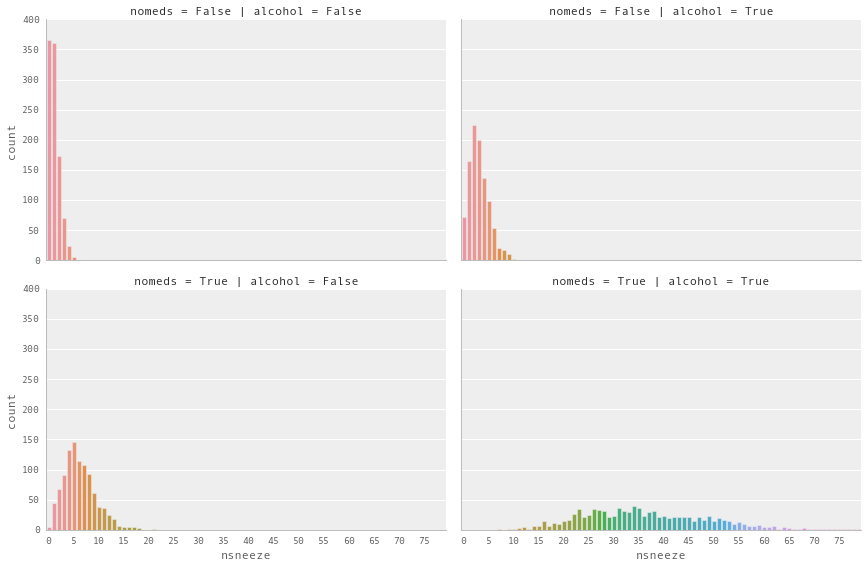

In [16]:
g = sns.factorplot(x = 'nsneeze', row = 'nomeds', col = 'alcohol', data = df, kind = 'count',
                  aspect = 1.5)

## Make x-axis tickslabels less crowded
ax = g.axes[1, 0]
labels = np.arange(len(ax.get_xticklabels(which = 'both')))
ax.set_xticks(labels[::5])
ax.set_xticklabels(labels[::5]);

In [17]:
## Create the GLM model
fml = 'nsneeze ~ alcohol + nomeds + alcohol:nomeds'

with pm.Model()as NBR_model:
    
    # the model
    family = pm.glm.families.NegativeBinomial()
    pm.glm.glm(formula = fml, data = df, family = family)
    
    # Optimization, seems to improvr mixing
    start = pm.find_MAP(fmin = scipy.optimize.fmin_powell)
    step = pm.NUTS(scaling = pm.approx_hessian(start))
    
    #sampling
    trace = pm.sample(20000, start = start, step = step)
    burned_NBR = trace[10000:]
    

AttributeError: module 'pymc3.glm.families' has no attribute 'NegativeBinomial'

In [ ]:
rvs = [rv.name for rv in strip_derived_rvs(NBR_model.unobserved_RVS)]
plot_traces(burned_NBR, varnames = rvs);

In [ ]:
## Transform coefficients to recover parameter values
np.exp(pm.df_summary(burned_NBR, varnames = rvs)[['mean','hpd_2.5', 'hpd_97.5']])

The $mean$ $values$ are close to the values specified when generating the data. The $base$ $rate$ is a constant 1.
    Drinking alcohol triple the base rate
    Not taking antihistamines increases the base rate by 6 times
    Drinking alcohol and not taking antihistamines doubles the rate taht would be expected if thier rates were independent
    If they were independent then doing both would increase the base rate by $3*6$ = $18$ $times$, but instead the base rate is increased by $3*6*2$ = $36$ $times$
    
Finally, even though the sample fo $mu$ is highly $skewed$, it $median$ value is close to the sample mean,and the mean of $alpha$ is also quite close to its actual value of 10 (see below)

In [ ]:
np.precentile(burned_NBR['mu'], [25, 50, 75])

In [ ]:
df.nsneeze.mean()

In [ ]:
burned_NBR['alpha'].mean()